In [1]:
# Choose your fighters
import PyPDF2
import os
import itertools as it
import statistics
from sentence_transformers import SentenceTransformer, util
import re
import csv 

from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
from unicodedata import normalize
import json
from string2string.alignment import SmithWaterman
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pkg_resources
from collections import Counter
from itertools import islice
import datetime

cwd = os.getcwd()

In [ ]:
# Open questions

# How to clean pdfs? Try using claude
# How to normalize sw score? DONE
# Automated method lacks way of detecting semantic content or origin of bill
# Examples of what would like to find - two bill sections with high overlap

In [2]:
sbert = SentenceTransformer('all-MiniLM-L6-v2')

sw = SmithWaterman(
    match_weight=2, # weight for a match
    mismatch_weight=-1, # weight for a mismatch
    gap_weight=0, # weight for a gap
    gap_char='-' # character to use for a gap
)

In [11]:
'''
Setup sample tests for SBERT + Smith-Waterman 
'''

# original clause
s1 = "To promote the progress of science and useful arts"
# longer version
s2 = "To promote the progress of science and useful arts, by securing for limited times to authors and inventors the exclusive right to their respective writings and discoveries"
# switch order of a few articles 
s3 = "The promote to progress and science of useful arts"
# switch progress and promote
s4 = "To progress the promote of art and useful science"
# misspellings
s5 = "Tu prmoote the prgreoss of sceince nad fuluse sart"
# different words with same number of characters in original order 
s6 = "The boost to advance and learn of clever crafts"
# different words with same number of characters in new order
s7 = "Birds fly over farms to spot the crops and fields"
# restatement of concept of original clause
s8 = "To encourage and advance the study and knowledge of practical, valuable skills and techniques"
# exact same clause with one word added
s9 = "To promote the progress of science and useful arts extra"
# same clause with spaces
s10 = "To   promote    the   progress     of   science   and    useful  arts"
# another synonyms
s11 = "To boost to advancement of technology, artistic scientific progress"
# exact same clause 
s12 = "To promote the progress of science and useful arts"

test_list = {"s1": s1,"s2": s2,"s3": s3,"s4": s4,"s5": s5,"s6": s6,"s7": s7,"s8": s8,"s9": s9,"s10": s10, "s11": s11,"s12": s12}

In [37]:
# https://stackoverflow.com/questions/46975929/how-can-i-calculate-the-jaccard-similarity-of-two-lists-containing-strings-in-py
def jaccard_similarity(list1, list2):
    s1 = set(list1.split())
    s2 = set(list2.split())
    return float(len(s1.intersection(s2)) / len(s1.union(s2)))

In [38]:
raw_sw_scores = []
lowest_sw = 0
highest_sw = 0
cherry = []
for a,b in it.combinations(test_list, 2):
    # Calculate embeddings and cosine similarity
    embedding_one = sbert.encode([test_list[a]])
    embedding_two = sbert.encode([test_list[b]])
    cos_score = util.cos_sim(embedding_one.reshape(1, -1), embedding_two.reshape(1, -1))[0][0]
    
    # Calculate raw Smith-Waterman score
    raw_sw_score = sw.get_alignment_score(test_list[a], test_list[b])
    raw_sw_scores.append(raw_sw_score)

    if raw_sw_score < lowest_sw:
        lowest_sw = raw_sw_score

    if raw_sw_score > highest_sw:
        highest_sw = raw_sw_score

    # Calculate Jaccard Similiarity
    jaccard = jaccard_similarity(test_list[a], test_list[b])

    # Store vals in array
    cherry.append([test_list[a], test_list[b], float(cos_score), raw_sw_score, a, b, jaccard])

# Shift to make all sw scores non-negative 
shifted_scores = [x + abs(lowest_sw) for x in raw_sw_scores] 

# Calculate mean and standard deviation
mean = statistics.mean(shifted_scores)  
std_dev = statistics.stdev(shifted_scores)

for item in cherry:
    # Convert sw score to z-score
    z_score = (item[3] - mean) / std_dev 
    max_min = (item[3] - mean) / (highest_sw - lowest_sw)
    print(f"Cosine Similarity: {item[2]:.4f}\t Jaccard: {item[6]:.4f}")
    print(f"S-W (z-score): {z_score:.4f}\t S-W (max-min): {max_min:.4f}")
    print(f"{item[4]}: {item[0]}")
    print(f"{item[5]}: {item[1]}")
    print("-" * 50)

Cosine Similarity: 0.7533	 Jaccard: 0.3333
S-W (z-score): 0.9599	 S-W (max-min): 0.2567
s1: To promote the progress of science and useful arts
s2: To promote the progress of science and useful arts, by securing for limited times to authors and inventors the exclusive right to their respective writings and discoveries
--------------------------------------------------
Cosine Similarity: 0.8702	 Jaccard: 0.6364
S-W (z-score): -0.8644	 S-W (max-min): -0.2312
s1: To promote the progress of science and useful arts
s3: The promote to progress and science of useful arts
--------------------------------------------------
Cosine Similarity: 0.9080	 Jaccard: 0.8000
S-W (z-score): -1.5851	 S-W (max-min): -0.4240
s1: To promote the progress of science and useful arts
s4: To progress the promote of art and useful science
--------------------------------------------------
Cosine Similarity: 0.2016	 Jaccard: 0.1250
S-W (z-score): -0.4590	 S-W (max-min): -0.1228
s1: To promote the progress of science 

# Pairwise Semantic Similarity & S-W Local Alignment
**Output csv:** paragraph1, paragraph2, semantic_similarity, overlap_similarity, bill1, bill2

In [2]:
sw = SmithWaterman(
    match_weight=2, # weight for a match
    mismatch_weight=-1, # weight for a mismatch
    gap_weight=0, # weight for a gap
    gap_char='-' # character to use for a gap
)

In [3]:
filepath = "/Users/ellismims/Documents/F23/256/anti-trans-legislation/bills/CO-HB1081.pdf"

_, extension = os.path.splitext(filepath)
with open(filepath, "rb") as file:
    if extension == ".pdf":
        reader = PyPDF2.PdfReader(file, strict=False)
        text = ""
        for page_num in range(len(reader.pages)):
            page = reader.pages[page_num]
            text += page.extract_text()
    elif extension == ".html":
        soup = BeautifulSoup(file, "html.parser")
        text = soup.get_text(strip=True)
    else:
        raise ValueError(f"{filepath}: Unsupported file format")

text = re.sub(r'\r\n', ' ', text) 
text = re.sub(r'§', 'section', text)
text = re.sub(r'[^a-zA-Z.;:\']', ' ', text)
text = re.sub(r'\s+', ' ', text)
# text = re.sub(r'[^\w\s]','',text)
# text = [word_tokenize(t) for t in sent_tokenize(text.lower())] 
text = sent_tokenize(text)

In [4]:
sentences = []
for sent in text:
    if (sent.count(' ') + 1) > 2:
        sentences.append(sent.lower())

sentences

['first regular session seventieth general assembly state of colorado introduced lls no.',
 'christy chase x house bill house committees senate committees state veterans military affairs a bill for an act concerning the protection of physical privacy in sex segregated locker rooms .',
 'bill summary note: this summary applies to this bill as introduced and does not reflect any amendments that may be subsequently adopted.',
 'if this billpasses third reading in the house of introduction a bill summary thatapplies to the reengrossed version of this bill will be available athttp: www.leg.state.co.us billsummaries .',
 'under current law a person is subject to a claim of discrimination in places of public accommodation if the person restricts access to asex segregated place of public accommodation to individuals based ontheir biological sex.',
 "the bill permits a person to restrict access to a sex segregated locker room based on an individual's actual biological sex.",
 'house sponsorship

In [103]:
''' 
Step 1: Split in Sections 
'''

def extract_and_sec_split(filepath):
    _, extension = os.path.splitext(filepath)
    with open(filepath, "rb") as file:
        if extension == ".pdf":
            reader = PyPDF2.PdfReader(file, strict=False)
            text = ""
            for page_num in range(len(reader.pages)):
                page = reader.pages[page_num]
                text += page.extract_text()
        elif extension == ".html":
            soup = BeautifulSoup(file, "html.parser")
            text = soup.get_text(strip=True)
        else:
            raise ValueError(f"{filepath}: Unsupported file format")

        # TODO adjust all of this cleaning 
        # Proposed process---> 
        # Tokenize
        # Remove numbers
        # Remove stop words (?)
        # Lower case
        # Spell checking
        # Substitute contractions  
        # Convert § to 'section' <- use LexNLP to do this & related tasks 
        # Convert acronyms to regular expressions <- LexNLP ? 
        # Remove some punctuation & special characters <- LexNLP ? 
        # Text Normalization - Stemming and Lemmatization

        text = normalize('NFKD', text).lower() 
        text = re.sub(r'\r\n', ' ', text) 
        text = re.sub(r'§', 'section', text)
        text = re.sub(r'[^a-zA-Z.;:\']', ' ', text)
        text = re.sub(r'\s+', ' ', text)

    # Split into sections
    sections = []
    for section in re.split(r'section', text):
        # Drop sections that have fewer than n words 
        # if len(section) > 8:
        sections.append(section)
    return sections

In [76]:
# TODO Pull bills from LegiScan API

bills = {}
subdir = os.path.join(cwd, "bills")

for bill in os.listdir(subdir):
    filename, extension = os.path.splitext(bill)
    if extension == ".pdf" or extension == ".html":
        data = extract_and_sec_split(os.path.join(subdir, bill))
        bills[filename] = data   

In [108]:
# Export to CSV
now = datetime.datetime.utcnow()
date_time = str(now.strftime("%Y%m%d_%H%M"))
with open(f'cherry-{date_time}.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(cherry)

# RESULTS

In [3]:
date = "20231020_2203"
col_names = ["paragraph1", "paragraph2", "semantic_similarity", "overlap_similarity", "bill1", "bill2"] 
# TODO write this to find the largest cherry-[0-9]* filename rather than be given file name 
df = pd.read_csv(f"cherry-{date_time}.csv", names=col_names, header=None)

In [4]:
print(df.shape)
df.head()

(19872, 6)


,paragraph1,paragraph2,semantic_similarity,overlap_similarity,bill1,bill2
0,rob introduced version bill text re by pen aha...,session of house bill not by committee on fede...,0.629845,-171.0,TX-HB2801,KS-HB2737
1,rob introduced version bill text re by pen aha...,a the provisions of,0.313896,-21.0,TX-HB2801,KS-HB2737
2,rob introduced version bill text re by pen aha...,s through and amendments thereto shall be know...,0.544806,-157.0,TX-HB2801,KS-HB2737
3,rob introduced version bill text re by pen aha...,s through and amendments thereto a sex means t...,0.462513,-169.0,TX-HB2801,KS-HB2737
4,rob introduced version bill text re by pen aha...,a where a student may be in a state of undres...,0.435133,-181.0,TX-HB2801,KS-HB2737


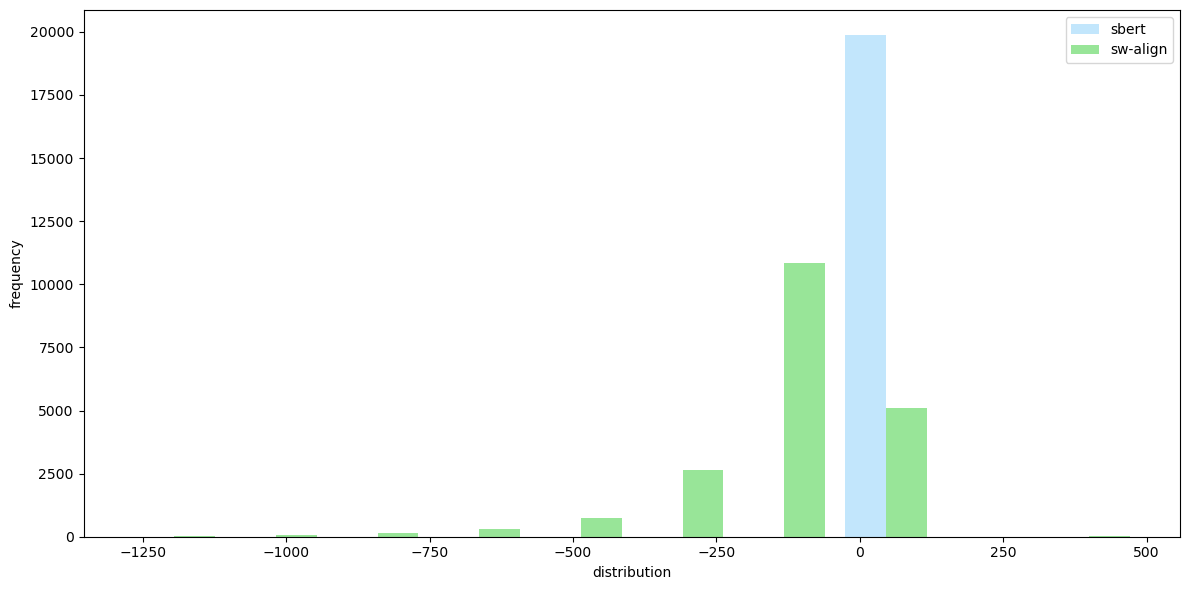

In [5]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.hist([df["semantic_similarity"], df["overlap_similarity"]], color=['lightskyblue','limegreen'], label=['sbert','sw-align',], 
         linewidth=0, alpha=0.5)

ax.legend()
plt.xlabel("distribution")
plt.ylabel("frequency")
plt.tight_layout()
plt.show();

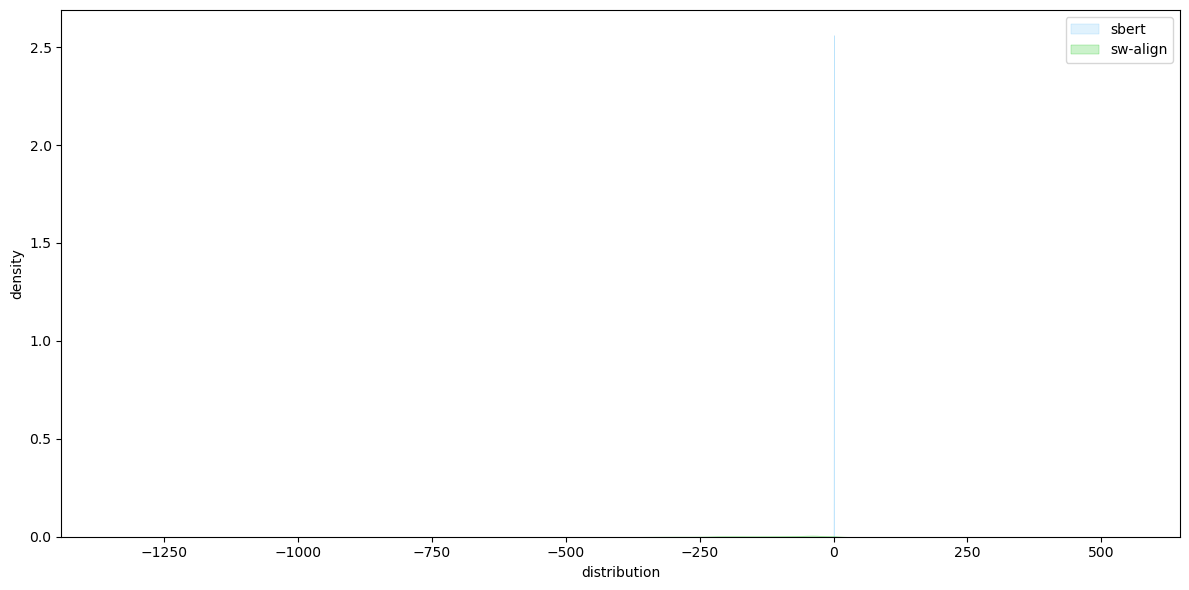

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(data=df["semantic_similarity"],
            color='lightskyblue', label='sbert', fill=True, ax=ax, linewidth=.2)
sns.kdeplot(data=df["overlap_similarity"],
            color='limegreen', label='sw-align', fill=True, ax=ax, linewidth=.2)
ax.legend()
plt.xlabel("distribution")
plt.ylabel("density")
plt.tight_layout()
plt.show()

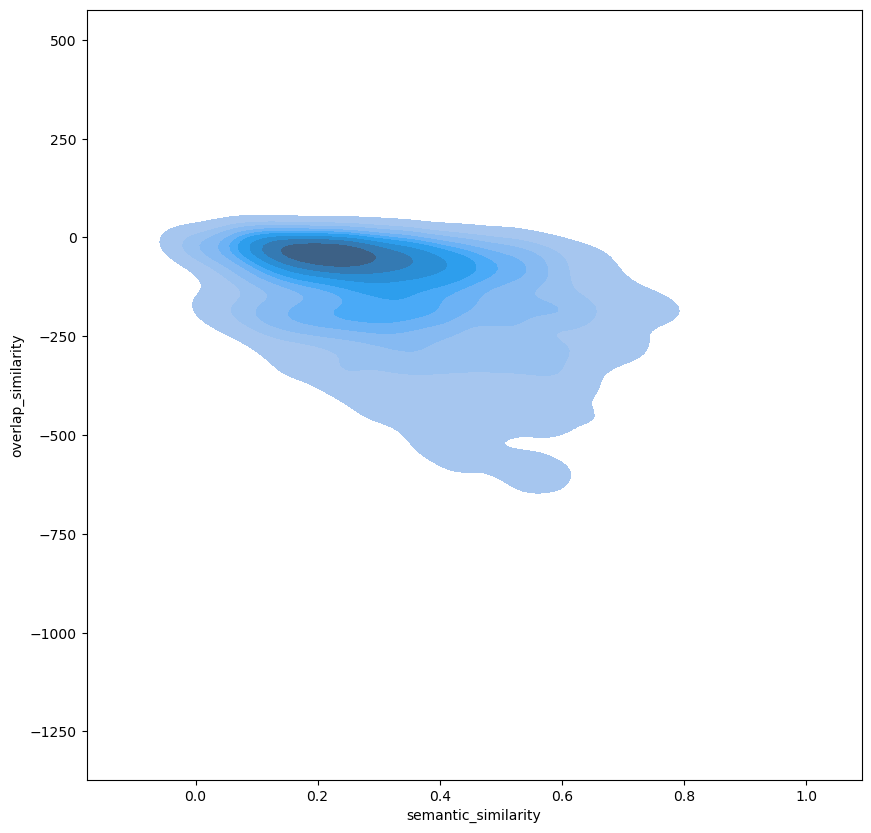

In [7]:
plt.figure(figsize=(10, 10))
sns.kdeplot(data=df, x="semantic_similarity", y="overlap_similarity", fill=True);
plt.show()

## No longer using this code ---->

In [ ]:
from urllib import request

url = "https://www.gutenberg.org/ebooks/25326.txt.utf-8"

response = request.urlopen(url)
raw = response.read()
text = raw.decode("utf-8-sig")
text = re.sub(r'\r\n', ' ', text) 
text = re.sub(r'§', 'section', text)
text = re.sub(r'[^a-zA-Z.;:\']', ' ', text)
text = re.sub(r'\s+', ' ', text)
text = sent_tokenize(text)
text = text[:5]

test_list = {"text":text, "another_text":another_text, "one_text":one_text, "dog_text":dog_text}

# Make substitutions for test examples

one_text = []
for sent in text:
    sent = re.sub(r'the', r'one', sent)
    one_text.append(sent)

dog_text = []
for sent in text:
    sent = re.sub(r'the', r'dog', sent)
    dog_text.append(sent)

another_text = []
for sent in text:
    sent = re.sub(r'the', r'another', sent)
    another_text.append(sent)

# Compute pairwise semantic similarity and local alignment 
num_test = len(test_list)
cherry = []

# Iterate through sentences
for i, (name_i, sect_i) in enumerate(test_list.items()):
    # Iterate through sentences
    for j, (name_j, sect_j) in enumerate(test_list.items()):
        # Skip if comparing the same sentence
        if i != j:
            # Compare each section from bill i with each section from bill j
            for section_i in sect_i:
                embedding_one = sbert.encode([section_i])

                for section_j in sect_j:
                    # Calculate embeddings and cosine similarity
                    embedding_two = sbert.encode([section_j])
                    cos_score = util.cos_sim(embedding_one.reshape(1, -1), embedding_two.reshape(1, -1))[0][0]
                    
                    # Calculate normalized Smith-Waterman score
                    sw_score = sw.get_alignment_score(section_i, section_j)

                    # Store vals in array
                    cherry.append([section_i, section_j, float(cos_score), sw_score, name_i, name_j])

largest_sw = [0,0,0,0,0,0]
largest_sbert = [0,0,0,0,0,0]
smallest_sw = [100,100,100,100,100,100]
smallest_sbert = [100,100,100,100,100,100]
for item in cherry:
    # print(f"Cosine Similarity: {item[2]}, Normalized S-W Score: {item[3]}")
    # print(f"{item[4]}: {item[0]}")
    # print(f"{item[5]}: {item[1]}")
    # print("-" * 50)
    if item[2] > largest_sbert[2]:
        largest_sbert = item
    if item[3] > largest_sw[3]:
        largest_sw = item    
    if item[2] < smallest_sbert[2]:
        smallest_sbert = item
    if item[3] < smallest_sw[3]:
        smallest_sw = item   

print("Largest Smith-Waterman value")
print("-" * 60)
print(f"Cosine Similarity: {largest_sw[2]}, Normalized S-W Score: {largest_sw[3]}")
print(f"{largest_sw[4]}: {largest_sw[0]}")
print(f"{largest_sw[5]}: {largest_sw[1]}\n")

print("Largest SBERT value")
print("-" * 60)
print(f"Cosine Similarity: {largest_sbert[2]}, Normalized S-W Score: {largest_sbert[3]}")
print(f"{largest_sbert[4]}: {largest_sbert[0]}")
print(f"{largest_sbert[5]}: {largest_sbert[1]}\n")

print("Smallest Smith-Waterman value")
print("-" * 60)
print(f"Cosine Similarity: {smallest_sw[2]}, Normalized S-W Score: {smallest_sw[3]}")
print(f"{smallest_sw[4]}: {smallest_sw[0]}")
print(f"{smallest_sw[5]}: {smallest_sw[1]}\n")

print("Smallest SBERT value")
print("-" * 60)
print(f"Cosine Similarity: {smallest_sbert[2]}, Normalized S-W Score: {smallest_sbert[3]}")
print(f"{smallest_sbert[4]}: {smallest_sbert[0]}")
print(f"{smallest_sbert[5]}: {smallest_sbert[1]}")    

In [ ]:
from symspellpy import SymSpell, Verbosity


In [2]:
"""
Create Combined Law Frequency Dictionary
"""
cwd_dict = os.path.join(cwd,"dictionaries/")

# Read Blacks Law Dictionary (2nd Ed) into file
blacks_second_edition = set()
with open(cwd_dict+'blacks_second_edition_terms.csv', 'r', encoding='utf-8') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        blacks_second_edition.add(row[0].strip().lower()) 

# Read billsum dataset from JSONL file
billsum_data = []
with open(cwd_dict+'us_train_data_final_OFFICIAL.jsonl', 'r', encoding='utf-8') as file:
    for line in file:
        data = json.loads(line)
        billsum_data.append(data['text'])

# Tokenize words in billsum dataset
tokenized_words = re.findall(r'\b\w+\b', ' '.join(billsum_data).lower())

# Count frequencies of words from Blacks Law dictionary in billsum dataset
word_frequencies = Counter(word for word in tokenized_words if word in blacks_second_edition)

# Append counts to existing counts for original 
law_df = pd.DataFrame.from_dict(word_frequencies, orient='index').reset_index()
law_df.rename(columns={"index": "word", 0: "frequency"}, inplace=True)
freq_dict_df = pd.read_csv(cwd_dict+'frequency_dictionary_en_82_765.txt', encoding='utf-8', sep=" ", names=["word", "frequency"])
print(f"Frequency dictionary entires:  {freq_dict_df.shape[0]}")
print(f"Law dictionary entires:  {law_df.shape[0]}")

# Merge dfs
merged_df = pd.merge(law_df, freq_dict_df, on='word', how='outer')
merged_df['frequency_x'].fillna(0, inplace=True)
merged_df['frequency_y'].fillna(0, inplace=True)

# Calculate shared frequencies & slice
merged_df['total_frequency'] = merged_df['frequency_x'] + merged_df['frequency_y']
merged_df = merged_df[['word', 'total_frequency']]
merged_df.sort_values(by='total_frequency', ascending=False, inplace=True)
print(f"Total entires:  {merged_df.shape[0]}")

# Export to CSV
merged_df.to_csv(cwd_dict+'plus_law_frequencies.csv', index=False, header=False)

In [74]:
sym_spell = SymSpell()
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"
)
sym_spell.load_dictionary(dictionary_path, 0, 1)
print(list(islice(sym_spell.words.items(), 5)))


# TODO fix weird bug where need to open with Excel and resave before will load to dictionary
# Initialize models and prepare dictionary
model = SentenceTransformer('all-MiniLM-L6-v2')
sw = SmithWaterman(
    match_weight=2, # weight for a match
    mismatch_weight=-1, # weight for a mismatch
    gap_weight=0, # weight for a gap
    gap_char='-' # character to use for a gap
)

sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = cwd_dict+"plus_law_frequencies.csv"

# Load dictionary (custom dict of ~83,000 words from standard freq dict plus Blacks Law Dictionary)
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1, separator=',')  # term_index: column of term, count_index: column of term's frequency
print(list(islice(sym_spell.words.items(), 5)))

[('the', 23135851162), ('of', 13151942776), ('and', 12997637966), ('to', 12136980858), ('a', 9081174698)]


In [ ]:
def symspell_corrector(input_term):
  # Look up suggestions for multi-word input strings 
  suggestions = sym_spell.lookup_compound( 
      phrase=input_term,  
      max_edit_distance=2,  
      transfer_casing=False,  
      ignore_term_with_digits=False, 
      ignore_non_words=True, 
      split_by_space=False 
  ) 
  # Implement the correction
  for suggestion in suggestions: 
      return f"{suggestion.term}"